# Prior predictive checking 

[Prior predictive checking](https://mc-stan.org/docs/2_25/stan-users-guide/prior-predictive-checks.html) is a crucial step in Bayesian statistics that helps assess the appropriateness of the chosen prior distribution for the model parameters. This process involves simulating hypothetical data sets from the prior distribution and comparing them to the observed data to evaluate the plausibility of the prior. If the prior predicts data that are not consistent with the observed data, it may indicate that the prior is misspecified and needs to be adjusted. Prior predictive checking can help identify potential problems with the model and ensure that the posterior distribution obtained from Bayesian analysis is reliable and accurate. By evaluating the validity of the prior distribution, prior predictive checking can help researchers make more informed decisions based on Bayesian analysis.

In [1]:
import logging
logger = logging.getLogger('cmdstanpy')
logger.setLevel(logging.CRITICAL)

import os
import tqdm
import numpy as np
from scipy import stats

from cmdstanpy import cmdstan_path, CmdStanModel, set_cmdstan_path, install_cmdstan

import matplotlib.pyplot as plt
import matplotlib
import arviz as az
plt.style.use('science')

import sys
sys.path.append('../scripts/python')
    
from parameter_estimation import BivariateBeta

The following function samples from distribution of the moments given that $\alpha$ has a given prior:

**1)** $\alpha \sim \operatorname{Gamma}(a,a)$

**2)** $\alpha \sim \operatorname{Gamma}(2,a)$

**3)** $\alpha \sim \operatorname{Gamma}(a,1)$

**4)** $\alpha_i \sim \operatorname{Gamma}(a_i,1), i=1,\dots,4$

**5)** $\alpha \sim \operatorname{Unif}(0,C)$ with prob $p$ and $\alpha \sim \operatorname{Exp}(\lambda) + C$ with prob $1-p$.

In [8]:
def moments_sampler(a, seed, prior=1):
    rng = np.random.RandomState(seed=seed)
    moments_samples = np.zeros((10000, 5))
    for i in range(moments_samples.shape[0]):
        if prior == 1:
            alpha = rng.gamma(shape=a, scale=1/a, size=4)
        elif prior == 2:
            alpha = rng.gamma(shape=2, scale=1/a, size=4)
        elif prior == 3:
            alpha = rng.gamma(shape=a, scale=1, size=4)
        elif prior == 4:
            alpha = rng.gamma(shape=a, scale=1)
        elif prior == 5:
            p, C, lamdb = a[0], a[1], a[2]
            S = rng.binomial(n=1, p=p, size=4) == 1
            alpha = np.zeros(4)
            alpha[S] = rng.uniform(0,C, size=S.sum())
            alpha[~S] = rng.exponential(lambd, size=4-S.sum()) + C
        distribution = BivariateBeta(alpha)
        moments_samples[i] = distribution.moments()
    return moments_samples

From that, we can observe that, given a prior distribution on $\alpha$, what is the induced on the moments. 

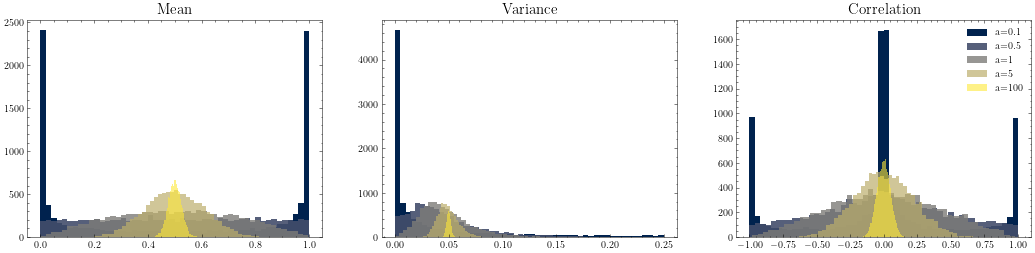

In [7]:
seed = 8393213
a_values = [0.1, 0.5, 1, 5, 100]

fig, ax = plt.subplots(1,3,figsize=(18,4))
colors = matplotlib.cm.get_cmap('cividis', len(a_values))
for j, a in enumerate(a_values):
    for i in range(3):
        samples = moments_sampler(a, seed)
        ax[i].hist(samples[:,2*i], bins=50, color=colors(j), label='a={}'.format(a), alpha=1-j*0.1)
        ax[i].set_title(['Mean', 'Variance', 'Correlation'][i], fontsize=15)
plt.legend()
plt.show()

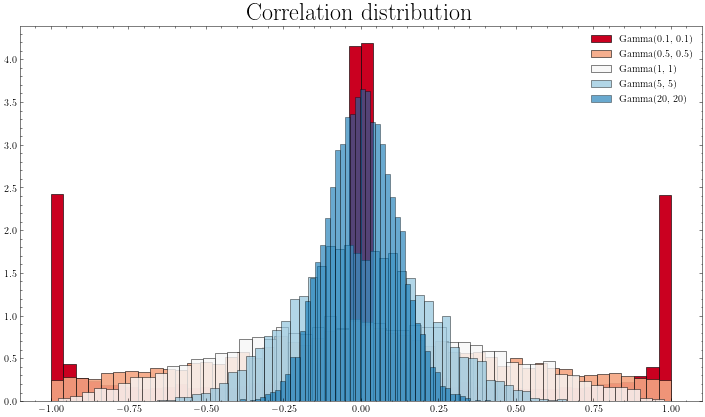

In [8]:
seed = 8393213
a_values = [0.1, 0.5, 1, 5, 20]

fig, ax = plt.subplots(figsize=(10,6))
colors = ['#ca0020','#f4a582','#f7f7f7','#92c5de','#0571b0']
for j, a in enumerate(a_values):
    samples = moments_sampler(a, seed)
    ax.hist(samples[:,-1], bins=50, density=True,
            color=colors[j], label='Gamma({}, {})'.format(a, a), alpha=1-j*0.1,
            edgecolor='black', linewidth=0.6)
    ax.set_title('Correlation distribution', fontsize=24)
plt.legend()
plt.tight_layout()
plt.savefig('../figures/correlation-distribution-gamma-a-a.pdf', bbox_inches='tight')
plt.show()

Consider the case $\alpha_i \sim Gamma(2, b)$. 
Notice however that if $\alpha_i \sim Gamma(2, 1)$, then $c\alpha \sim Gamma(2,1/c)$. 
Therefore, 
$$
m_1 = \frac{c\alpha_1 + c\alpha_2}{\sum_{i=1}^4 c\alpha_i} = \frac{\alpha_1 + \alpha_2}{\sum_{i=1}^4 \alpha_i}
$$
does not depend on $c$. 
The same can be told about $m_2$ and $\rho$.

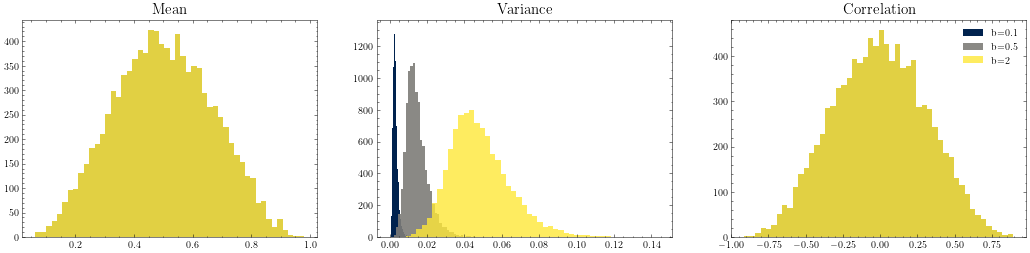

In [9]:
seed = 8393213
b_values = [0.1, 0.5, 2]

fig, ax = plt.subplots(1,3,figsize=(18,4))
colors = matplotlib.cm.get_cmap('cividis', len(b_values))
for j, b in enumerate(b_values):
    for i in range(3):
        samples = moments_sampler(b, seed, prior=2)
        ax[i].hist(samples[:,2*i], bins=50, color=colors(j), label='b={}'.format(b), alpha=1-j*0.1)
        ax[i].set_title(['Mean', 'Variance', 'Correlation'][i], fontsize=15)
plt.legend()
plt.show()

Consider $\alpha_i \sim Gamma(a, 1)$

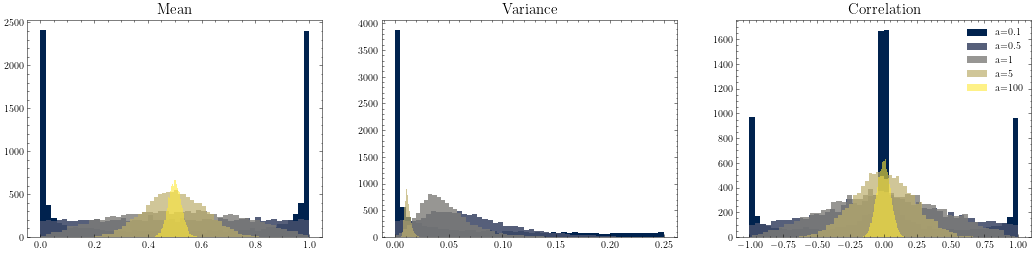

In [10]:
seed = 8393213
a_values = [0.1, 0.5, 1, 5, 100]

fig, ax = plt.subplots(1,3,figsize=(18,4))
colors = matplotlib.cm.get_cmap('cividis', len(a_values))
for j, a in enumerate(a_values):
    for i in range(3):
        samples = moments_sampler(a, seed, prior=3)
        ax[i].hist(samples[:,2*i], bins=50, color=colors(j), label='a={}'.format(a), alpha=1-j*0.1)
        ax[i].set_title(['Mean', 'Variance', 'Correlation'][i], fontsize=15)
plt.legend()
plt.show()

Notice that when the $\alpha$ values have the same distribution, $\rho$ is centered in zero, and the mean over 1/5. 
Moreover, when $a=0.5$, we are close to the uniform case.  
In special, mean and correlation do not depend on the rate parameter, as we already verified. 

Now, we change the prior distributions for each $\alpha_i$. Consider $\alpha_i \sim Gamma(a_i, 1)$.

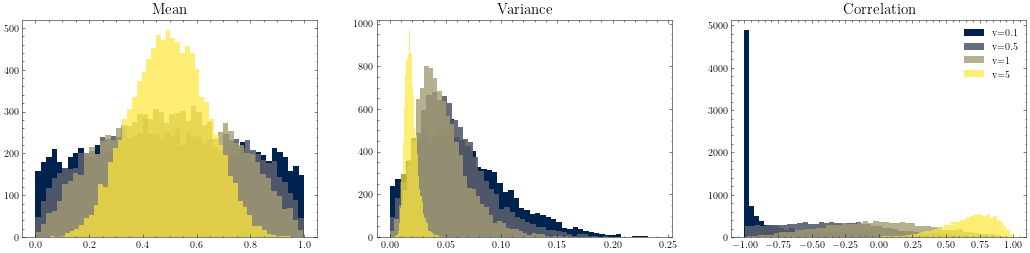

In [11]:
seed = 8393213
a_values = [0.1, 0.5, 1, 5]

fig, ax = plt.subplots(1,3,figsize=(18,4))
colors = matplotlib.cm.get_cmap('cividis', len(a_values))
for j, v in enumerate(a_values):
    for i in range(3):
        a = np.array([v, 1.0, 1.0, v])
        samples = moments_sampler(a, seed, prior=4)
        ax[i].hist(samples[:,2*i], bins=50, color=colors(j), label='v={}'.format(v), alpha=1-j*0.1)
        ax[i].set_title(['Mean', 'Variance', 'Correlation'][i], fontsize=15)
plt.legend()
plt.show()

What happens if we use the uniform as prior?

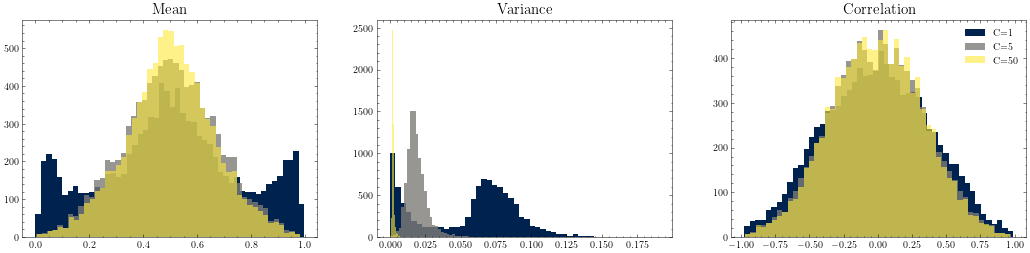

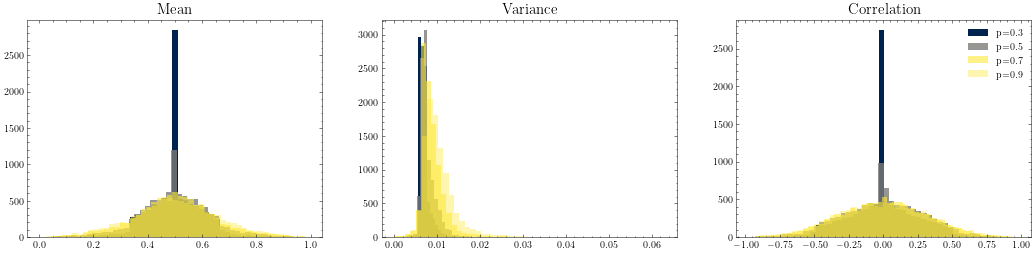

In [12]:
seed = 8393213
C_values = [1, 5, 50]
p = 0.9

fig, ax = plt.subplots(1,3,figsize=(18,4))
colors = matplotlib.cm.get_cmap('cividis', len(C_values))
for j, C in enumerate(C_values):
    for i in range(3):
        # This value of lambd guarantees that the density is continuous.
        lambd = p/C/(1-p)
        a = [p, C, lambd]
        samples = moments_sampler(a, seed, prior=5)
        ax[i].hist(samples[:,2*i], bins=50, color=colors(j), label='C={}'.format(C), alpha=1-j*0.2)
        ax[i].set_title(['Mean', 'Variance', 'Correlation'][i], fontsize=15)
plt.legend()
plt.show()

seed = 8393213
p_values = [0.3, 0.5, 0.7, 0.9]
C = 10

fig, ax = plt.subplots(1,3,figsize=(18,4))
colors = matplotlib.cm.get_cmap('cividis', len(C_values))
for j, p in enumerate(p_values):
    for i in range(3):
        # This value of lambd guarantees that the density is continuous.
        lambd = p/C/(1-p)
        a = [p, C, lambd]
        samples = moments_sampler(a, seed, prior=5)
        ax[i].hist(samples[:,2*i], bins=50, color=colors(j), label='p={}'.format(p), alpha=1-j*0.2)
        ax[i].set_title(['Mean', 'Variance', 'Correlation'][i], fontsize=15)
plt.legend()
plt.show()

## Posterior distribution for different priors

In this section, we compare the posterior distributions for different priors.
The model was coded in *Stan programming language*, which provides samples from the posterior distribution given an observed dataset and prior distributions for the parameters.

### Stan Model

For using the following notebook, it is necessary to set the `cmdstan` path correctly. 

In [2]:
set_cmdstan_path('/home/lucasmoschen/anaconda3/envs/project-beta/bin/cmdstan')

Then, we can proceed the compilation.

In [3]:
stanfile = os.path.join('..', 'scripts', 'stan', 'bivariate-beta-model-v1.stan')
model1 = CmdStanModel(stan_file=stanfile, cpp_options={'STAN_THREADS':True})

stanfile = os.path.join('..', 'scripts', 'stan', 'bivariate-beta-model-v2.stan')
model2 = CmdStanModel(stan_file=stanfile, cpp_options={'STAN_THREADS': True})

stanfile = os.path.join('..', 'scripts', 'stan', 'bivariate-beta-model-v3.stan')
model3 = CmdStanModel(stan_file=stanfile, cpp_options={'STAN_THREADS': True})

11:18:41 - cmdstanpy - INFO - compiling stan file /home/lucasmoschen/Documents/bivariate-beta/scripts/stan/bivariate-beta-model-v3.stan to exe file /home/lucasmoschen/Documents/bivariate-beta/scripts/stan/bivariate-beta-model-v3
11:19:01 - cmdstanpy - INFO - compiled model executable: /home/lucasmoschen/Documents/bivariate-beta/scripts/stan/bivariate-beta-model-v3


The function for generating the data from the Bivariate Beta model given a vector $\alpha$. 

In [4]:
def generate_data(true_alpha, n, seed):
    ro = np.random.RandomState(seed=seed)
    U = ro.dirichlet(true_alpha, size=n)
    X = U[:,0] + U[:,1]
    Y = U[:,0] + U[:,2]
    XY = np.column_stack([X,Y])
    return U[:,0], XY

Fitting the model and comparing the posterior distributions for different priors.

In [5]:
true_alpha = np.array([1,1,1,1])
n = 50
U, XY = generate_data(true_alpha, n, seed=783210)

# Gamma hyperparameters
a = np.ones(4)
b = np.ones(4)

# Boojum prior
m = -0.9
r = b

# Uniform-Exponential prior
p = 0.9*np.ones(4)
lambd = np.ones(4)
c = 10*np.ones(4)

# Prior_alpha = 1 -> gamma
# Prior_alpha = 2 -> boojum
# Prior_alpha = 4 -> Uniform Exponential
# Prior_alpha = 3 or 5 -> Improper distributions

data = {'prior_alpha': 1, 'a': a, 'b': b, 'm': m, 'r': r, 'p': p, 'lambda': lambd, 'c': c, 'n': n, 'x': XY[:,0], 'y': XY[:,1],
        'alpha': true_alpha, 'xy': XY}

In [17]:
model_fit1 = model3.sample(data=data, chains=4, iter_sampling=1000, show_progress=True)

11:32:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:25 - cmdstanpy - INFO - CmdStan done processing.
11:32:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable[1] is inf, but must be positive finite! (in '/home/lucasmoschen/Documents/bivariate-beta/scripts/stan/bivariate-beta-model-v3.stan', line 41, column 4 to column 24)
	Exception: gamma_lpdf: Random variable[1] is inf, but must be positive finite! (in '/home/lucasmoschen/Documents/bivariate-beta/scripts/stan/bivariate-beta-model-v3.stan', line 41, column 4 to column 24)
	Exception: gamma_lpdf: Random variable[1] is 0, but must be positive finite! (in '/home/lucasmoschen/Documents/bivariate-beta/scripts/stan/bivariate-beta-model-v3.stan', line 41, column 4 to column 24)
	Exception: gamma_lpdf: Random variable[2] is inf, but must be positive finite! (in '/home/lucasmoschen/Documents/bivariate-beta/scripts/stan/bivariate-beta-model-v3.stan', line 41, column 4 to column 24)
Consider re-running with show_console=True if the above output

In [11]:
model_fit1.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-12.902600,0.285398,8.203470,-27.278400,-12.196100,-0.537868,826.216,754.535,1.001990
alpha[1],1.136640,0.005087,0.218742,0.795991,1.124410,1.509940,1848.840,1688.440,1.001000
alpha[2],1.145860,0.006574,0.233485,0.785604,1.138190,1.550500,1261.500,1152.060,1.001400
alpha[3],0.982903,0.006304,0.215077,0.645752,0.969797,1.347740,1164.010,1063.020,1.001950
alpha[4],1.212260,0.005283,0.224337,0.860917,1.200780,1.607960,1803.470,1647.000,1.000340
...,...,...,...,...,...,...,...,...,...
u[46],0.292966,0.001980,0.114169,0.102018,0.300041,0.463265,3325.790,3037.250,1.000890
u[47],0.079201,0.000589,0.041691,0.010907,0.080367,0.141868,5002.540,4568.530,0.999770
u[48],0.215390,0.001260,0.088368,0.070663,0.217953,0.348247,4915.830,4489.340,0.999534
u[49],0.066023,0.000544,0.035054,0.008721,0.066824,0.118087,4149.750,3789.730,1.001880


In [39]:
print(model_fit1.diagnose())

Processing csv files: /tmp/tmp2e8a2fbg/bivariate-beta-model-v3c5d10ilg/bivariate-beta-model-v3-20220914105653_1.csv, /tmp/tmp2e8a2fbg/bivariate-beta-model-v3c5d10ilg/bivariate-beta-model-v3-20220914105653_2.csv, /tmp/tmp2e8a2fbg/bivariate-beta-model-v3c5d10ilg/bivariate-beta-model-v3-20220914105653_3.csv, /tmp/tmp2e8a2fbg/bivariate-beta-model-v3c5d10ilg/bivariate-beta-model-v3-20220914105653_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



## What else?

In [18]:
data['prior_alpha'] = 1
model_fit1 = model2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False)
data['prior_alpha'] = 2
model_fit2 = model2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False)
data['prior_alpha'] = 4
model_fit3 = model2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False)

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing


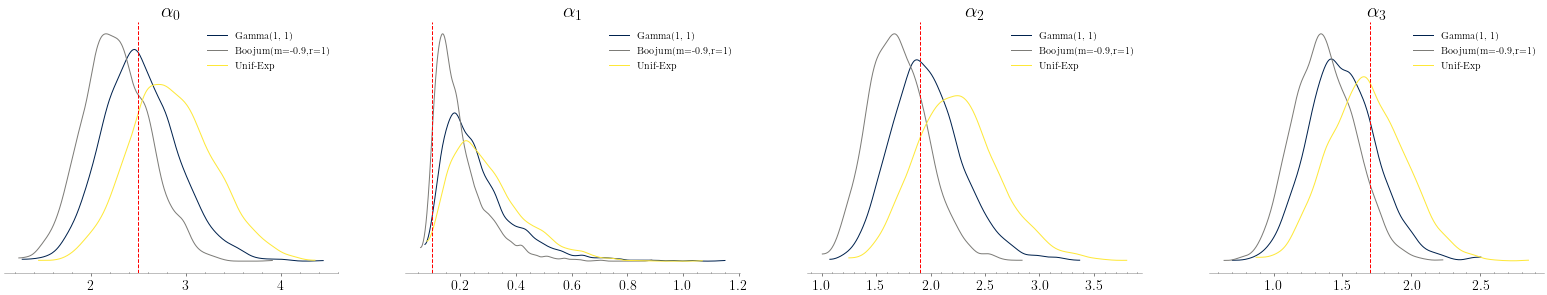

In [19]:
colors = matplotlib.cm.get_cmap('cividis', 3)
ax = az.plot_posterior(model_fit1, var_names=['alpha'], hdi_prob='hide', point_estimate=None, color=colors(0), label='Gamma(1, 1)')
az.plot_posterior(model_fit2, var_names=['alpha'], ax=ax, hdi_prob='hide', point_estimate=None, color=colors(1), label='Boojum(m=-0.9,r=1)')
az.plot_posterior(model_fit3, var_names=['alpha'], ax=ax, hdi_prob='hide', point_estimate=None, color=colors(2), label='Unif-Exp')

for i in range(4):
    ax[i].set_title(r'$\alpha_{}$'.format(i), fontsize=20)
    ax[i].axvline(true_alpha[i], color='red', linestyle='--')

plt.show()

In [20]:
data['prior_alpha'] = 1
model_fit1 = model3.sample(data=data, chains=4, iter_sampling=1000, show_progress=False)

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing


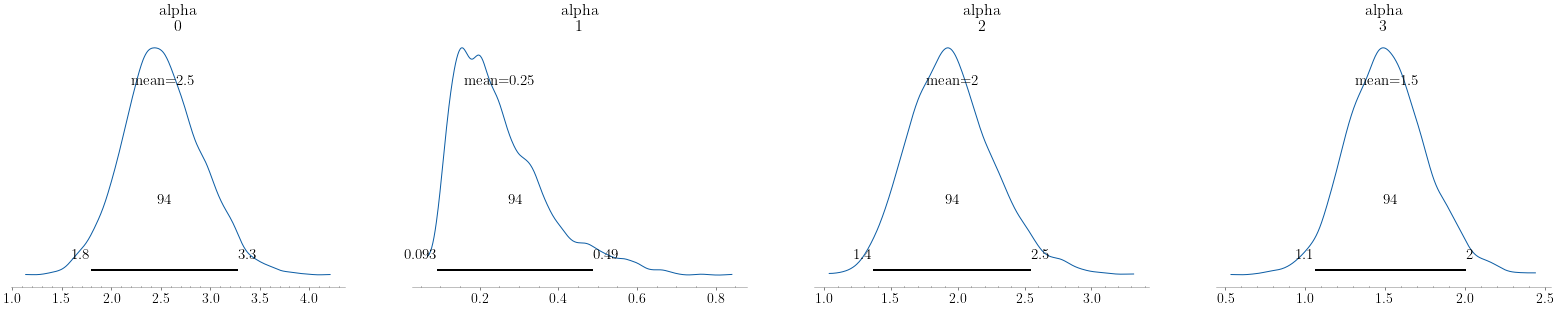

In [21]:
az.plot_posterior(model_fit1, var_names=['alpha'])
plt.show()

## Gain of increasing the dataset size

Here we vary the value of $n$ and see the posterior shape.

In [25]:
true_alpha = np.array([2,7,3,1])
n_values = [10, 50, 100, 500, 1000]
alpha_samples = np.zeros((len(n_values),4000,4))
data['prior_alpha'] = 1

for i, n in tqdm.tqdm(enumerate(n_values)):
    data['n'] = n
    data['xy'] = generate_data(true_alpha, n, seed=920392)[1]
    model_fit = model2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False, show_console=False)
    alpha_samples[i,:,:] = model_fit.stan_variable('alpha')

0it [00:00, ?it/s]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
1it [00:00,  2.44it/s]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
2it [00:01,  1.28it/s]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
3it [00:03,  1.22s/it]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
4it [00:15,  5.50s/it]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
5it [00:42,  8.50s/it]
